In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D

# 랜덤시드 고정시키기

np.random.seed(3)

In [17]:
# 데이터 생성 - 훈련 데이터 각 2000개, 검증 데이터 각 300개, 테스트 데이터 각 300개

# 300*300을 50*50으로 줄여서 학습시키도록 한다. 
# 훈련 데이터 수가 클래스당 2000개이므로 배치 크기를 5로 지정하면 400번 배치를 수행해 한 에포크 돌아감

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('galaxy_train',target_size=(50, 50),batch_size=5,class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory('galaxy_val',target_size=(50, 50),batch_size=5,class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('galaxy_test',target_size=(50,50),batch_size=5, shuffle=False, class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 900 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [18]:
# 모델 생성하기

model = Sequential()

# 11x11 필터를 96개를 사용, strides = 4, 활성화함수 = relu, 입력 데이터 크기 50x50 , 3x3 크기의 풀리계층 사용

model.add(Conv2D(96, (11,11), strides=4, input_shape=(50,50,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(BatchNormalization())

# 5X5 필터를 256개 사용 , strides = 1, 활성화함수 = relu, 3x3 크기의 풀리계층 사용

model.add(ZeroPadding2D(2))
model.add(Conv2D(256,(5,5), strides=1, activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(BatchNormalization())

# 3x3 필터를 384개 사용, strides =1 , 활성화함수 = relu

model.add(ZeroPadding2D(1))
model.add(Conv2D(384,(3,3), strides=1, activation='relu'))

# 3x3 필터를 384개 사용, strides =1 , 활성화함수 = relu

model.add(ZeroPadding2D(1))
model.add(Conv2D(384,(3,3), strides=1, activation='relu'))

# 3x3 필터를 256개 사용, strides =1 , 활성화함수 = relu, 1x1 크기의 풀리계층 사용

model.add(ZeroPadding2D(1))
model.add(Conv2D(256,(3,3), strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1), strides=2))

# 계산을 위해서 1차원 배열로 전환

model.add(Flatten())

# 4096개의 출력뉴런, 활성화함수 = relu

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# 4096게의 출력뉴런, 활성화함수 = relu

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# 3개의 출력뉴런, 활성화함수 = softmax

model.add(Dense(3, activation='softmax'))

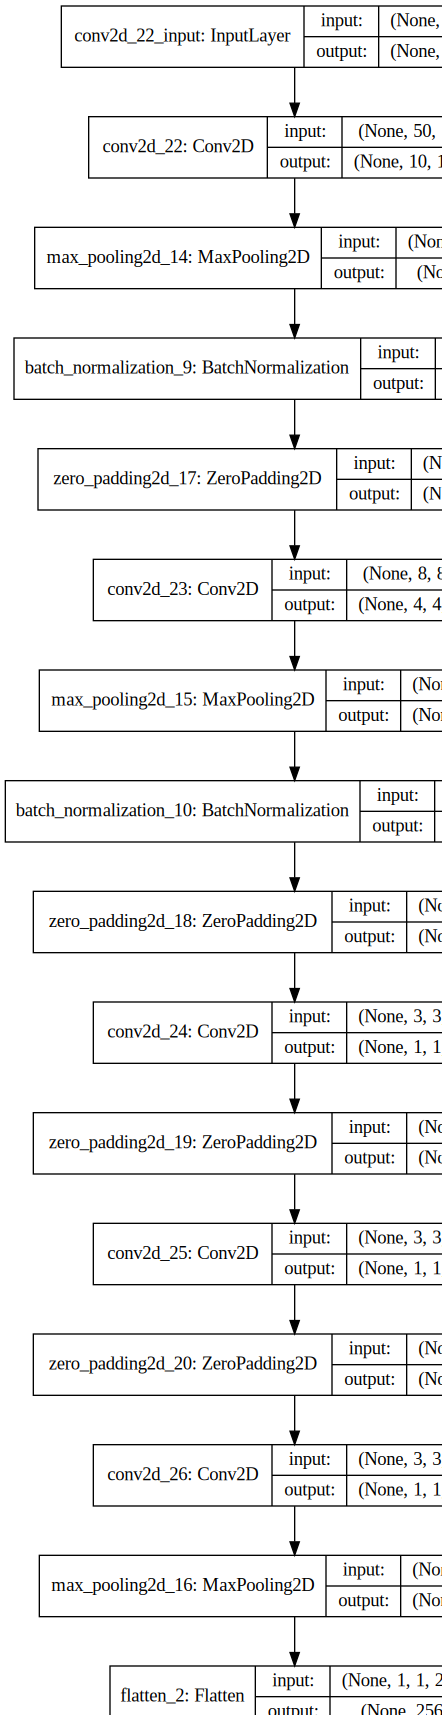

In [19]:
# 모델 가시화

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [21]:
# 모델 학습과정 설정

from keras.optimizers import Adam

Optimizer = Adam(lr = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=Optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 10, 10, 96)        34944     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 96)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 96)          384       
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1, 1, 256)        

In [ ]:
# 모델 학습시키기

# steps_per_epoch: 총 6000개의 데이터이고 batch_size=5이므로 1200스텝
# validation_steps: 총 900개의 검증 샘플이 있고 batch_size=5이므로 180스텝

hist = model.fit_generator(train_generator, steps_per_epoch=1200, epochs=50, validation_data = val_generator, validation_steps=180)

In [ ]:
# 모델 평가하기

print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=180)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

In [ ]:
# 모델 사용하기 (테스트 데이터에 대해 예측하기 (또는 그냥 예측하고 싶은 데이터를 제너레이터로 만들어서 넣으면 됨))

print("-- Predict --")
output = model.predict_generator(test_generator, steps=180)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(test_generator.class_indices)
print(output)
print()
print('\n'.join(test_generator.filenames))

In [ ]:
# 학습과정 살펴보기

print(hist.history['loss'])
print(hist.history['acc'])
print(hist.history['val_loss'])
print(hist.history['val_acc'])

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()